<a href="https://colab.research.google.com/github/MustafaKhan670093/Machine-Learning-Playbook/blob/master/Style%20Transfer%20With%20Deep%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer with Deep Neural Networks

In this project, I recreate a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In the paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers.

## Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, target image which should contain our desired content and style components:

* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

The key to doing this lies in the feature extraction (outlined in the linked paper) as well as the creation of the loss function. Then, by using gradient descent to optimize a total loss function (made of a content loss and a style loss), the network manages to extract the content of the content image and the style of the style image in order to produce the target image.

## Import Libraries

In [1]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load In VGG19 (Features)

VGG19 is split into two portions:

vgg19.features, which are all the convolutional and pooling layers
vgg19.classifier, which are the three linear, classifier layers at the end
We only need the features portion, which we're going to load in and "freeze" the weights of, below.

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

## Checking If GPU Is Available

In [3]:
# use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("The ML code in this project will be trained on " + str(device))

# move the model to GPU, if available
vgg.to(device)

The ML code in this project will be trained on cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Defining Helper Function To Load Images

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

## Load In Content Image And Style Image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [5]:
# load in content and style image
content = load_image('style_transfer_images/abandoned_house.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('style_transfer_images/the_scream.jpg', shape=content.shape[-2:]).to(device)

## Visualizing The Content Image And Style Image

In [6]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

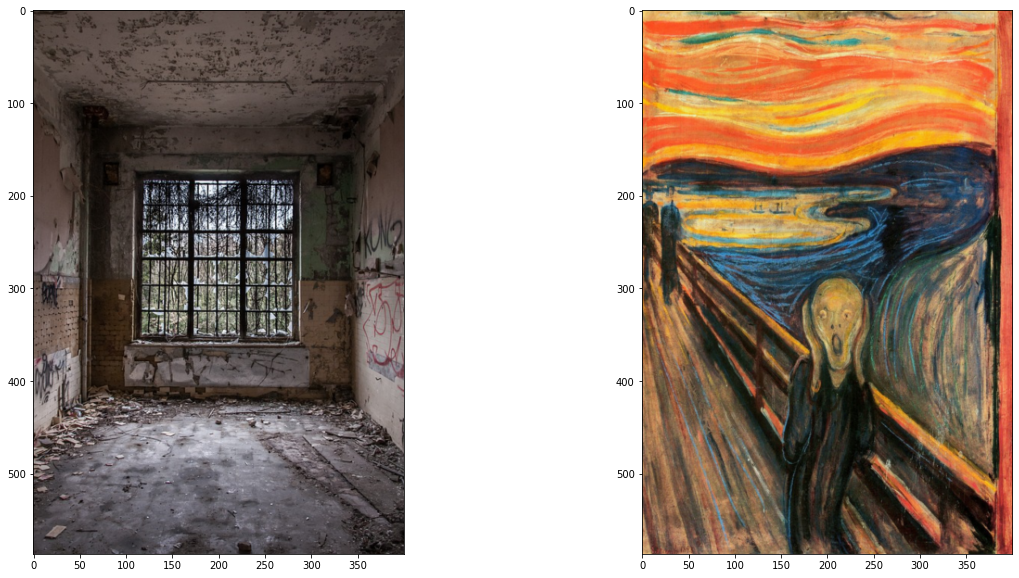

In [7]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## Obtaining Content And Style Features

In [8]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

## Calculating The Gram Matrix

The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth, d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:

* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose

*Note: You can multiply two matrices using torch.mm(matrix1, matrix2).*

In [9]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

## Putting It All Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer, let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [10]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

## Specifying Loss and Weights

### Individual Layer Style Weights

Below, is the option to weight the style representation at each relevant layer. It's suggested that a value between the range of 0-1 is used to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, there will be larger style artifacts in the resulting, target image. On the other hand, by choosing to weight later layers, there will be more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

### Content and Style Weight

Just like in the paper, I shall define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how *stylized* the final image is. It's recommended that to leave the `content_weight = 1` and set the style_weight to achieve the desired ratio.

In [11]:
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.75,
                 'conv4_1': 0.75,
                 'conv5_1': 0.75}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating The Target Image And Calculating Losses

The number of steps in which the image will be updated can be changed. Style transfer is similar to training ML models, except this time VGG19 or any other images aren't being changed, only the target image is. It is reccomended to use at least 2000 steps for good results.

Inside the iteration loop, the content and style losses will be calculated and the target image will be updated accordingly. 

### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows:

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

### Style Loss

The style loss is calculated in a similar way, only this is done by iterating through a number of layers, specified by name in the dictionary `style_weights`. At each of these layers, the gram matrix for the **target image** (**`target_gram`**) and the **style image** (**`style_gram`**) will be calculated. By comparing these two gram matrices, the **`layer_style_loss`** is calculated. (Note: This value is normalized by the size of the layer)

### Total Loss

Finally, you'the total loss will be created by adding up the style and content losses and weighting them with a specified alpha and beta! Intermittently, the loss will be printed. Don't be alarmed if the loss is very large. It takes some time for an image's style to change and the focus should be on the appearance of the target image rather than any loss value. Neverthless, after a number of iterations this loss value will indeed decrease.

Total loss:  34440788.0


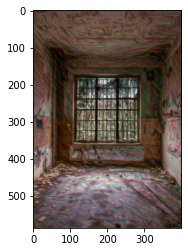

Total loss:  20518832.0


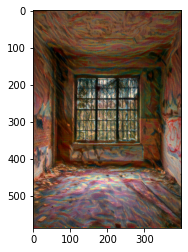

Total loss:  13757485.0


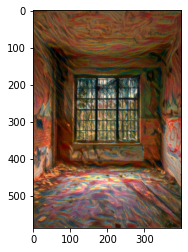

Total loss:  8500444.0


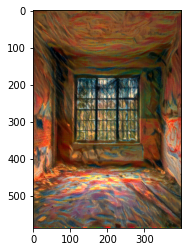

Total loss:  4438263.5


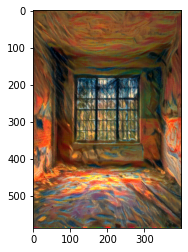

Total loss:  2305043.5


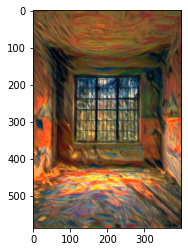

Total loss:  1423483.125


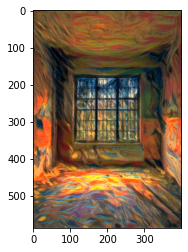

Total loss:  1022518.4375


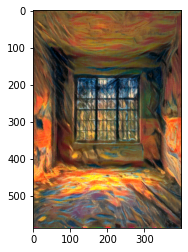

Total loss:  793995.9375


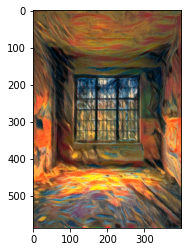

Total loss:  638247.5625


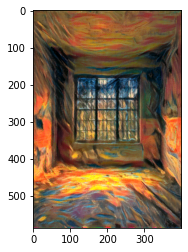

Total loss:  519425.875


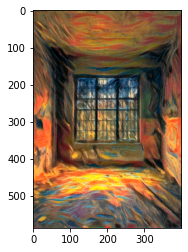

Total loss:  424246.28125


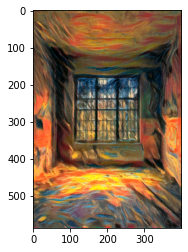

Total loss:  347062.09375


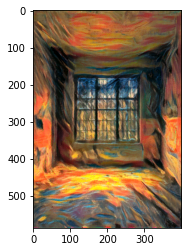

Total loss:  285114.84375


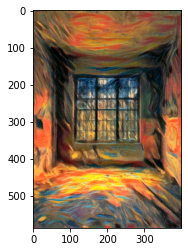

Total loss:  238243.1875


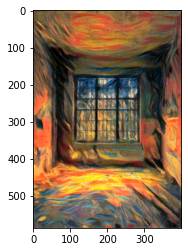

Total loss:  201812.5


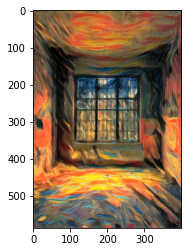

Total loss:  174549.8125


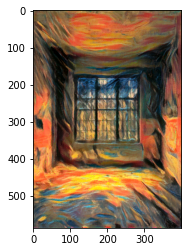

Total loss:  154716.296875


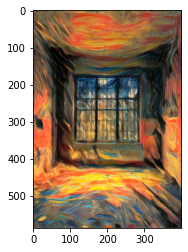

Total loss:  139153.5


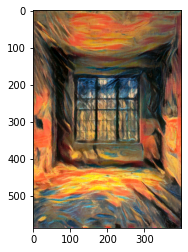

Total loss:  127928.5703125


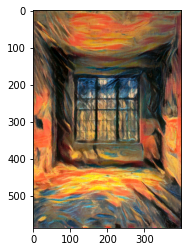

Total loss:  121723.5859375


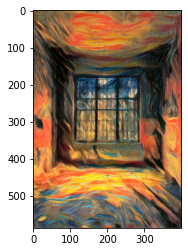

Total loss:  111354.7421875


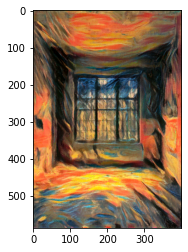

Total loss:  104561.5390625


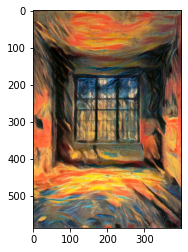

Total loss:  100939.6484375


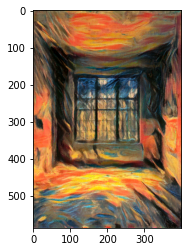

Total loss:  95404.484375


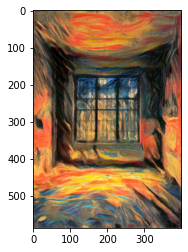

In [12]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 10000  # decide how many iterations to update your image 

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display The Target Image

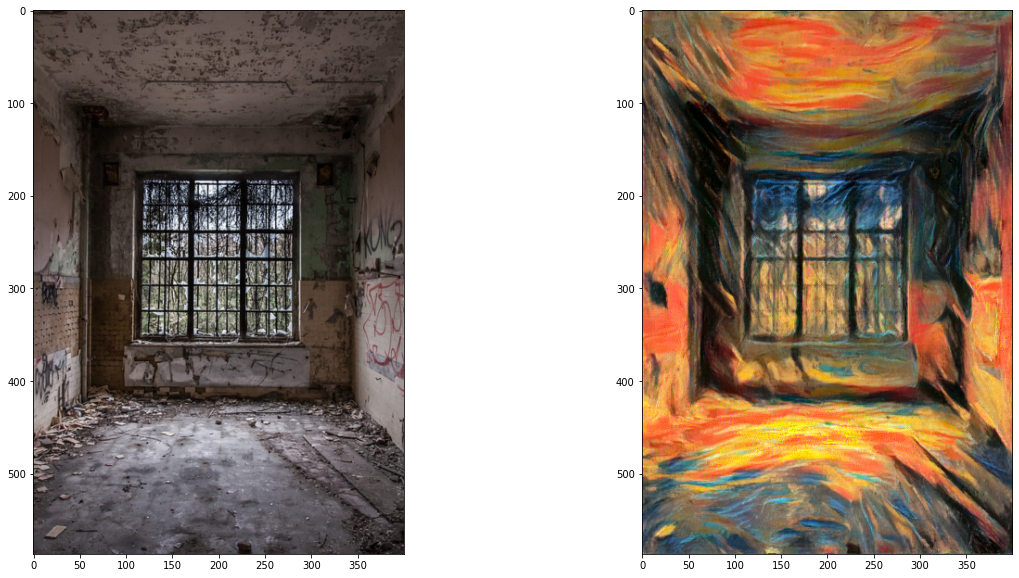

In [13]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))